# Example analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Major updates:
- 2018-09-28: creation
- 2018-12-10: reboot
- 2019-01-25: change import statement
- 2019-04-04: QC params with min/max thresholds | adata_redux is the final anndata object containing all fields recorded during analysis

In [3]:
from scanpy_recipes import sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

In [4]:
ac = sc.AnalysisConfig()

In [6]:
config_string = """
[names]
pi_name = Anonymous person
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
AJ17001 = LHA-Males

[genomes]
AJ17001 = mm10

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus
mm-c57bl6nj = mmusculus
mm-casteij = mmusculus

[input_dirs]
AJ17001 = /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/

[output_dirs]
AJ17001 = /fastscratch/seignm/singlecell/test_output

[target_cells]
AJ17001 = 6000

[10x_chemistry]
AJ17001 = v2

[cellranger_version]
AJ17001 = 2.2.0

[reference_version]
AJ17001 = 2.1.0
"""
config = ac.read(config_string)

In [7]:
adata_raw = sc.load_10x_data("AJ17001", config)

reading /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.31)
Ran `.var_names_make_unique()` for you.


In [8]:
raw_save_file = sc.save_adata(adata_raw, "raw")

Saving AJ17001-raw_20190405.h5ad to /fastscratch/seignm/singlecell/test_output.


## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.

In [9]:
adata_raw = sc.read_h5ad(raw_save_file)

In [10]:
sc.qc.gen_qc(adata_raw)

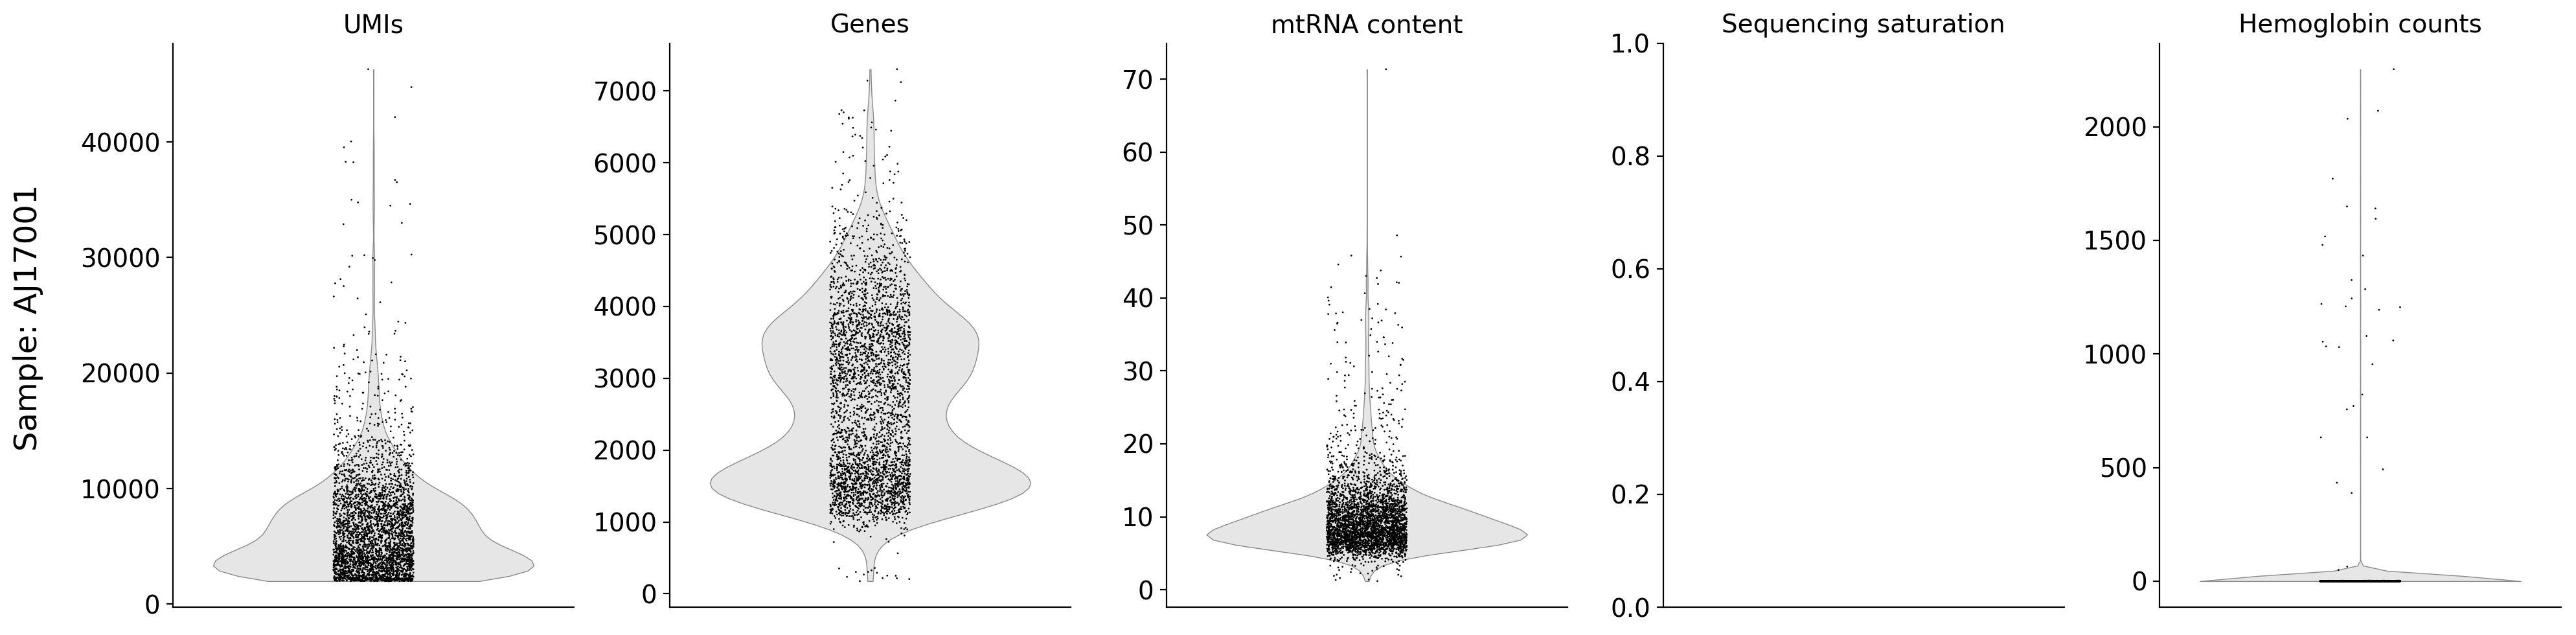

In [11]:
sc.pl.qc_violins(adata_raw)

In [12]:
qc_params = dict(
           min_cells_per_gene=3,
           min_counts_per_gene=3,
           min_genes_per_cell=200,
           max_genes_per_cell=8000,
           min_counts_per_cell=500,
           max_counts_per_cell=50000,
           max_pct_mitochondrial=30,
           max_counts_hemoglobin=2000
)

In [13]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)

filtered out 1 cells that have less than 200 genes expressed
filtered out 11421 genes that are detected in less than 3 cells
Original dims: (3439, 28692)
Filtered dims: (3382, 17271)


In [14]:
trial.obs.qc_fail.value_counts()

pass    3382
fail      57
Name: qc_fail, dtype: int64

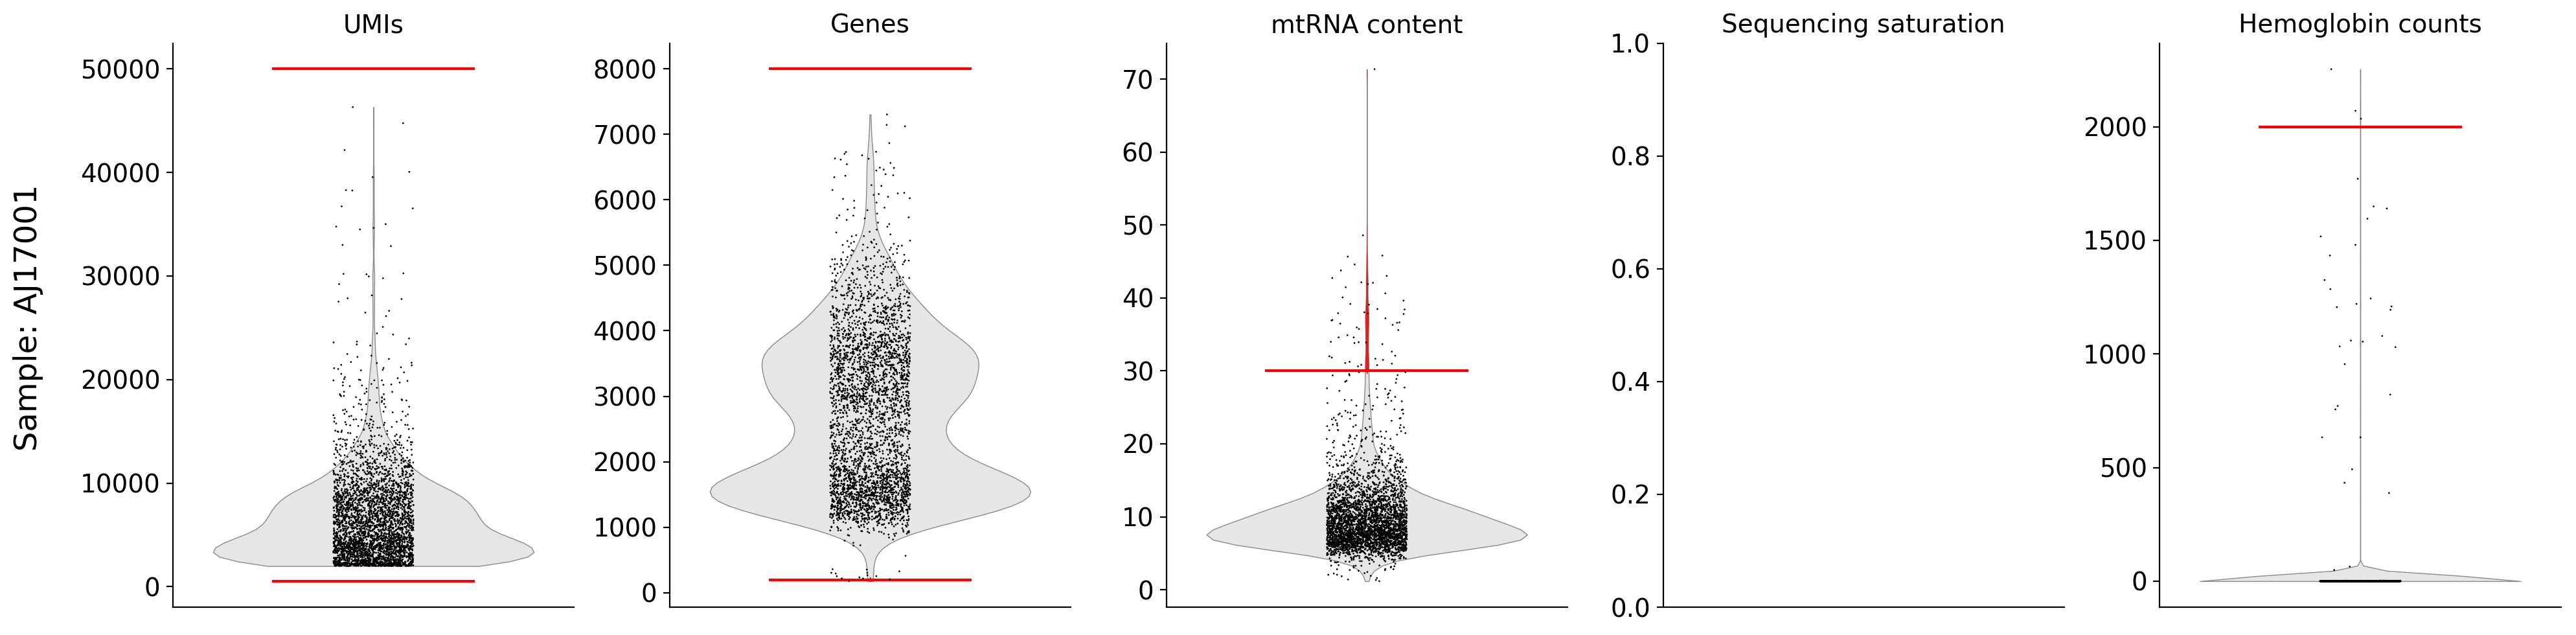

In [15]:
qc_fig1 = sc.pl.qc_violins(trial, return_fig=True)

In [16]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)
adata_qc = sc.qc.run_qc(adata_raw, trial=False, **qc_params)

filtered out 1 cells that have less than 200 genes expressed
filtered out 11421 genes that are detected in less than 3 cells
Original dims: (3439, 28692)
Filtered dims: (3382, 17271)
filtered out 1 cells that have less than 200 genes expressed
filtered out 11421 genes that are detected in less than 3 cells
Original dims: (3439, 28692)
Filtered dims: (3382, 17271)


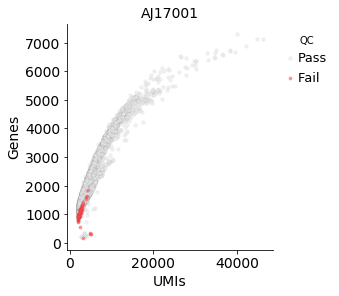

In [17]:
qc_fig2 = sc.pl.qc_pass_fail(trial, return_fig=True)

reading /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/raw_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:04.23)


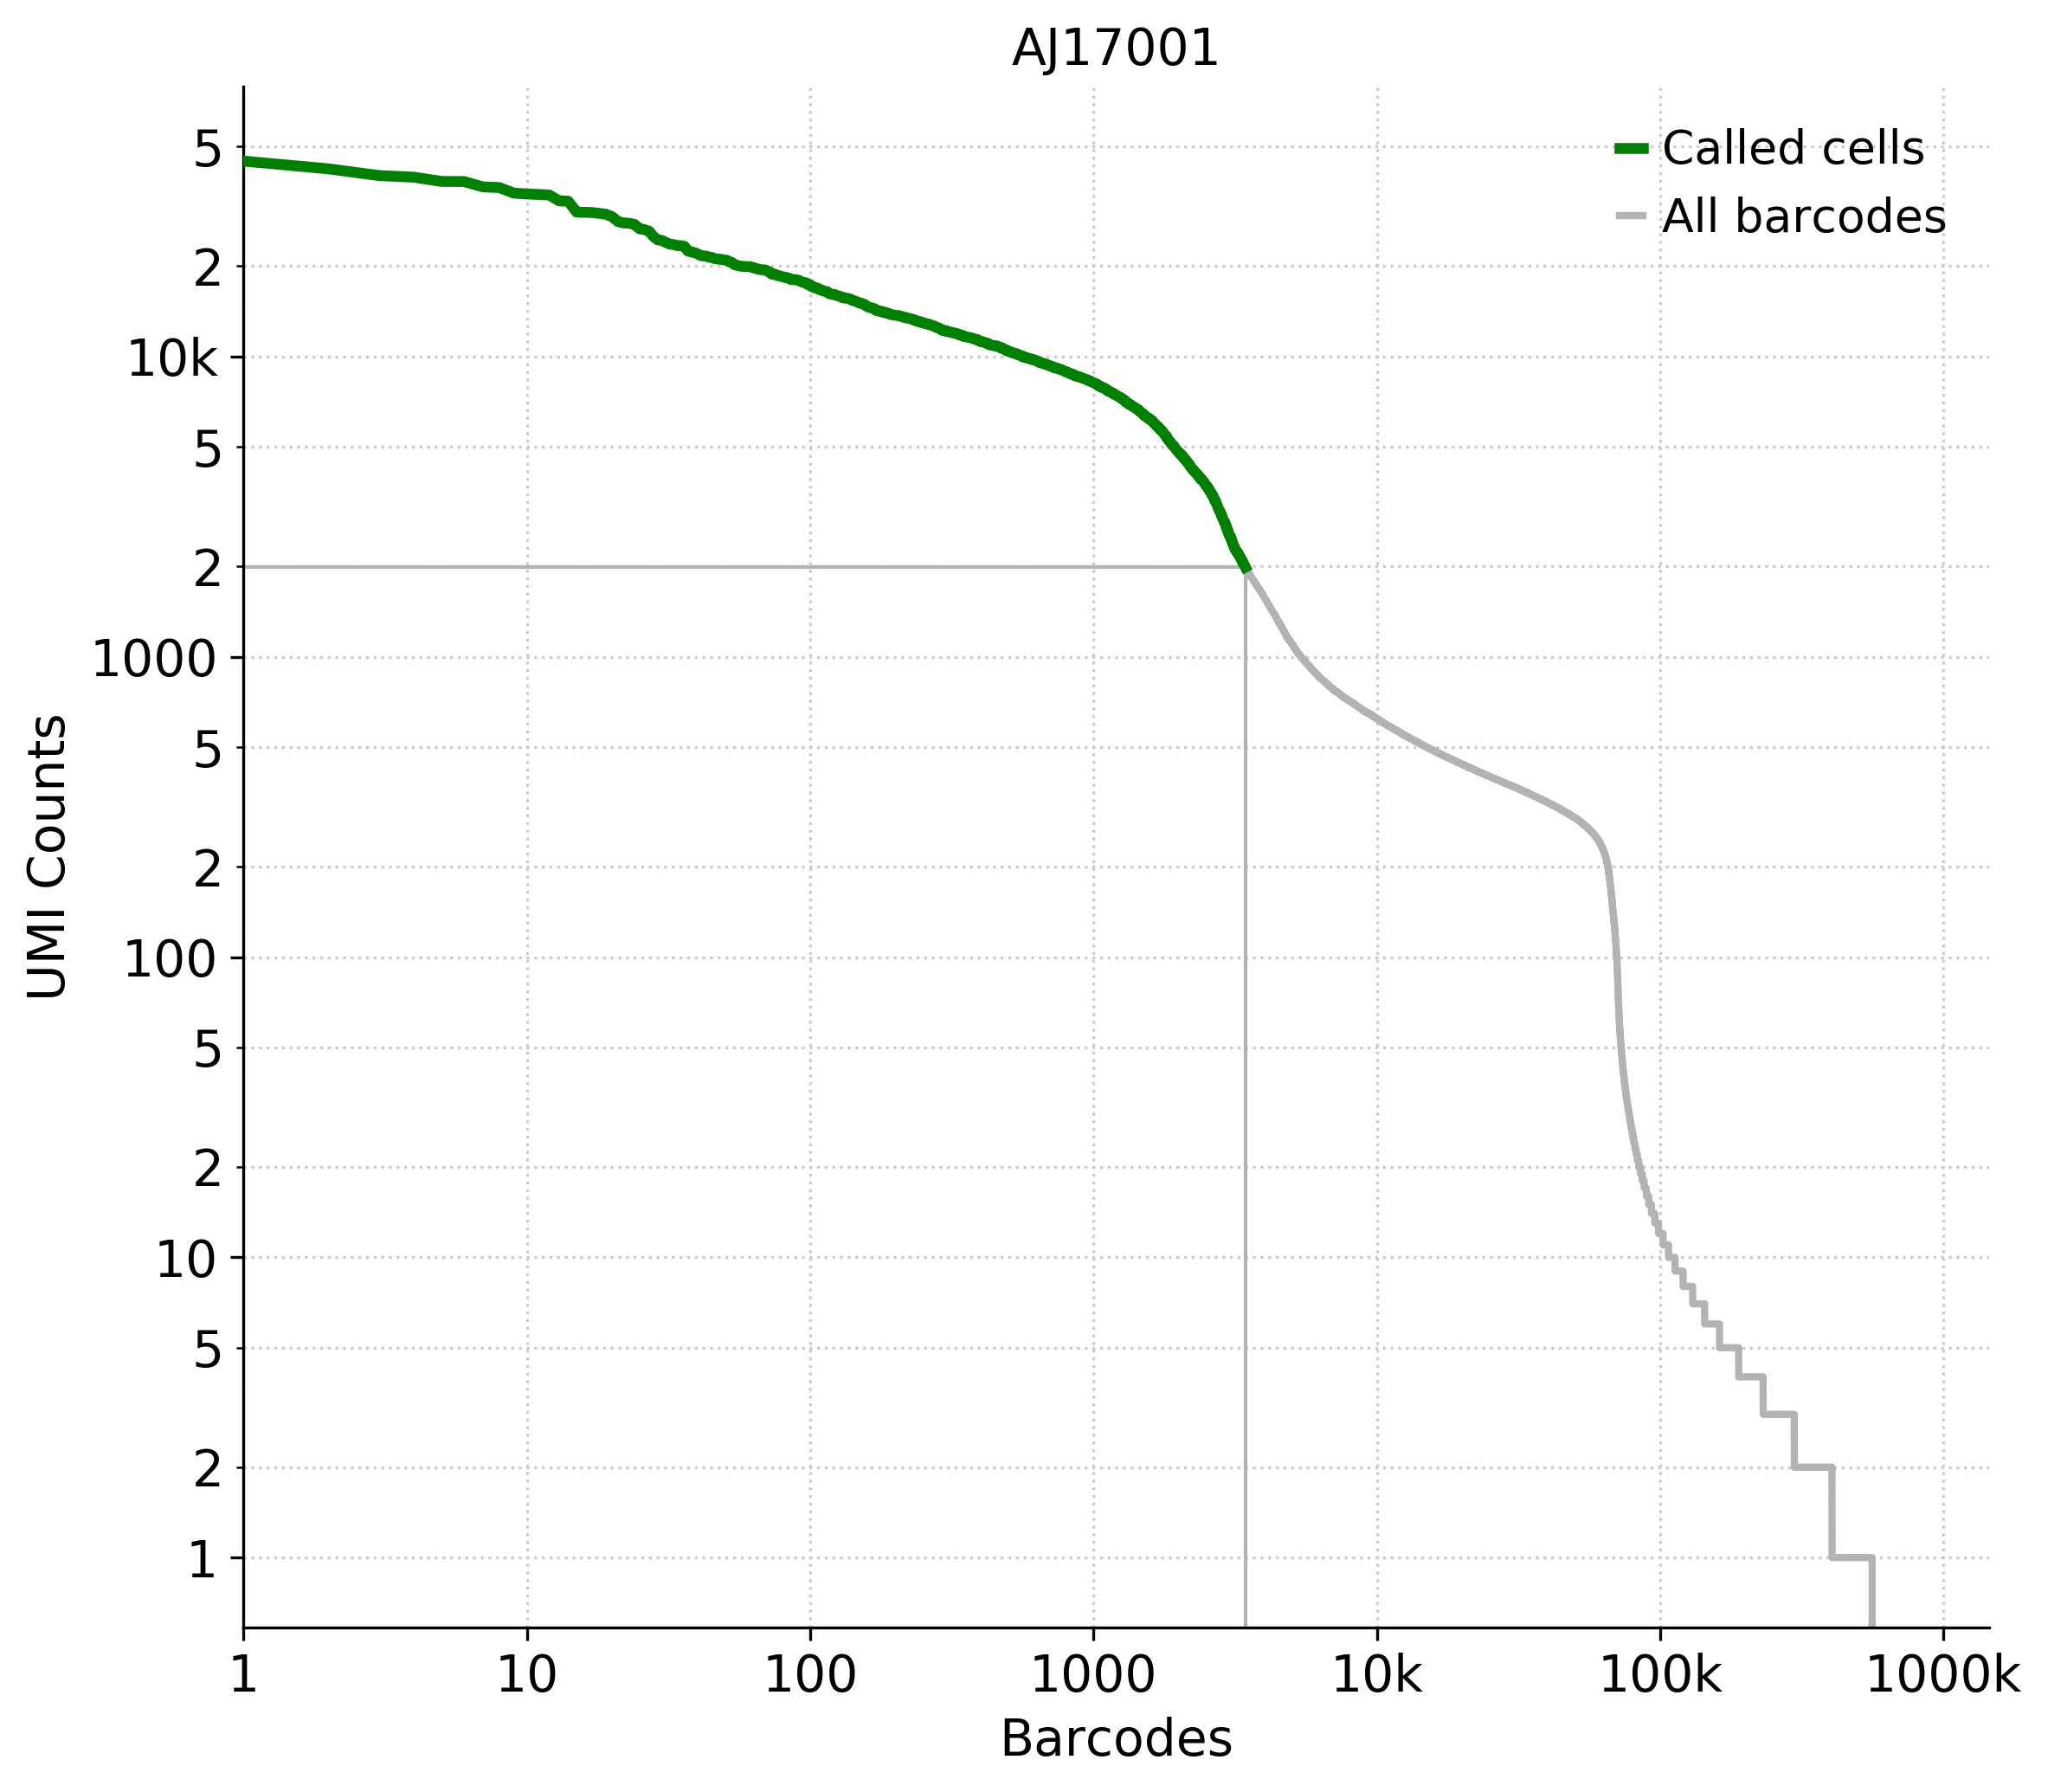

In [18]:
qc_fig3 = sc.pl.umi_rank_plot(adata_raw, return_fig=True)

In [19]:
qc_message = (
    "After QC, the cell-gene matrix contains {cells} cells and {genes} genes.\n"
    "1.  {low_count_genes_removed} were removed due to too few counts.\n"
    "2.  {cells_removed} were removed due to several factors.\n"
    "2a.  {low_count_cells_removed} were removed due to low UMI and gene counts.\n"
    "2b.  {red_blood_cells_removed} were removed due to high counts of hemoglobin markers.\n"
    "2c.  {high_mtrna_cells_removed} were removed due to high mtRNA content.\n"
    "2d.  {low_sequencing_saturation_cells_removed} were removed due to low per-cell sequencing saturation.\n")
print(qc_message.format(**trial.uns["qc_metrics"]))

After QC, the cell-gene matrix contains 3382 cells and 17271 genes.
1.  11421 were removed due to too few counts.
2.  57 were removed due to several factors.
2a.  0 were removed due to low UMI and gene counts.
2b.  3 were removed due to high counts of hemoglobin markers.
2c.  53 were removed due to high mtRNA content.
2d.  0 were removed due to low per-cell sequencing saturation.



In [20]:
qc_save_file = sc.save_adata(adata_qc, "qc")

Saving AJ17001-qc_20190405.h5ad to /fastscratch/seignm/singlecell/test_output.


## Highly variable gene selection and dimensionality reduction

In [35]:
adata_qc = sc.read_h5ad(qc_save_file)

In [36]:
adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)


In [37]:
sc.pp.dimensionality_reduction(adata_redux, n_neighbors=10, min_dist=0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01.35) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:12.03) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:12.83) --> added
    'X_umap', UMAP coordinates (adata.obsm)
2D UMAP available at `.obsm['X_umap']`
3D UMAP available at `.obsm['X_umap_3d']`


## Clustering

In [39]:
sc.tl.cluster(adata_redux,)

running Leiden clustering
    finished (0:00:00.46) --> found 29 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


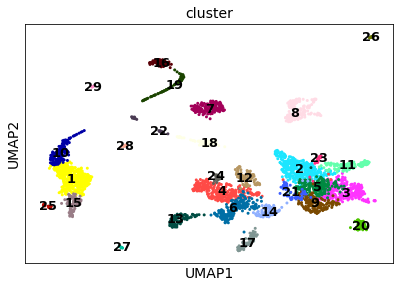

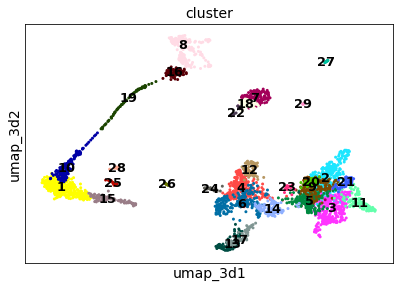

In [40]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")
sc.pl.scatter(adata_redux, basis="umap_3d", color="cluster", legend_loc="on data")

Visualize genes abundance with `"n_genes_by_counts"`, umis abundance with `"total_counts"` or visualize a specific gene's abundance with `["gene id"]`in all clusters 

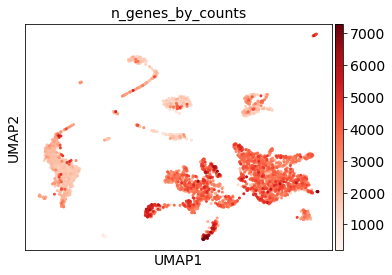

In [32]:
sc.pl.umap(adata_redux, color="n_genes_by_counts")

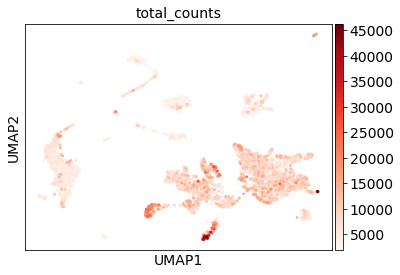

In [33]:
sc.pl.umap(adata_redux, color="total_counts")

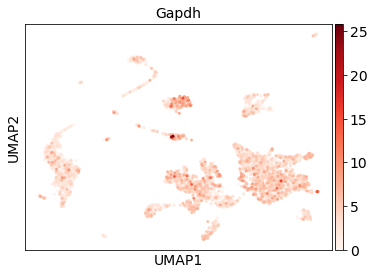

In [34]:
sc.pl.umap(adata_redux, color="Gapdh")

In [41]:
sc.tl.cluster(adata_redux, resolution=0.2)

running Leiden clustering
    finished (0:00:00.58) --> found 17 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


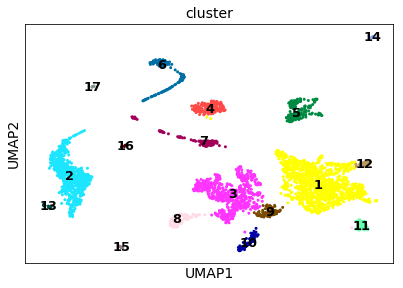

In [42]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")

In [43]:
sc.tl.subcluster(adata_redux, cluster="7", cluster_key="cluster")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 3 clusters and added
    'cluster_R1', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R1']`.


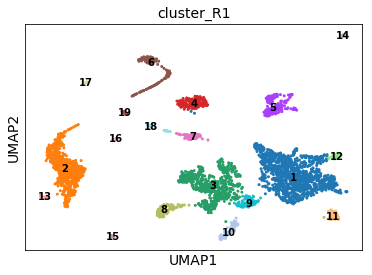

In [44]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

In [45]:
sc.tl.combine_clusters(adata_redux, cluster_ids=["1", "12"], cluster_key="cluster_R1")

Updated clusters under `adata.obs['cluster_R1']`.


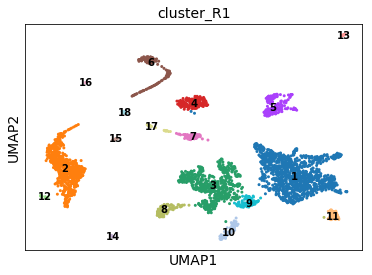

In [46]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

In [47]:
adata_redux.obs["cluster_R1"] = sc.tl.reorder_clusters(adata_redux.obs["cluster_R1"], [1, 9, 3, 8, 10, 11, 14, 2, 12, 16, 15, 18, 6, 17, 7, 4, 5, 13])

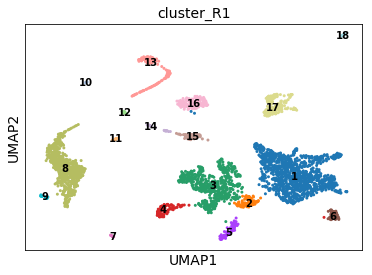

In [48]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

## Marker gene detection

In [50]:
markers = sc.tl.find_marker_genes(adata_redux, "cluster_R1", log_fold_change=1.0)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
Computed markers for 18 clusters.


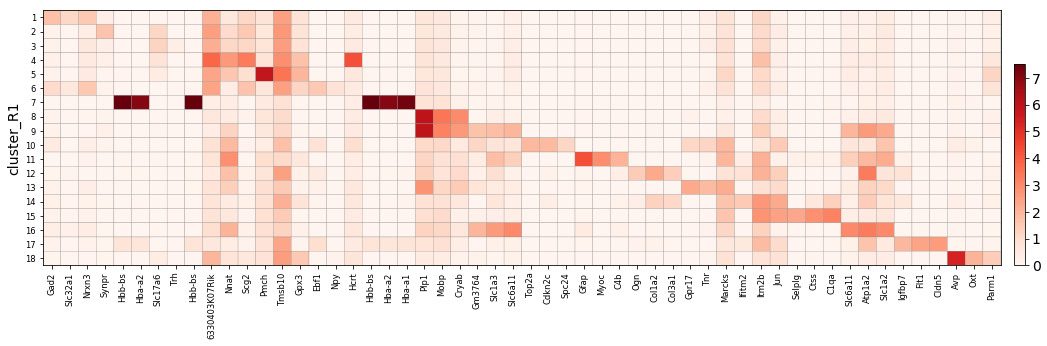

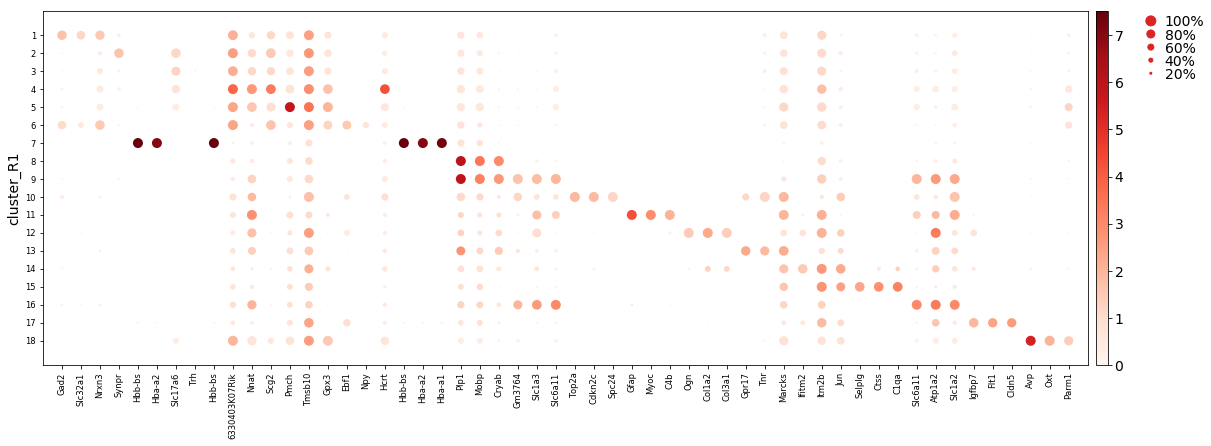

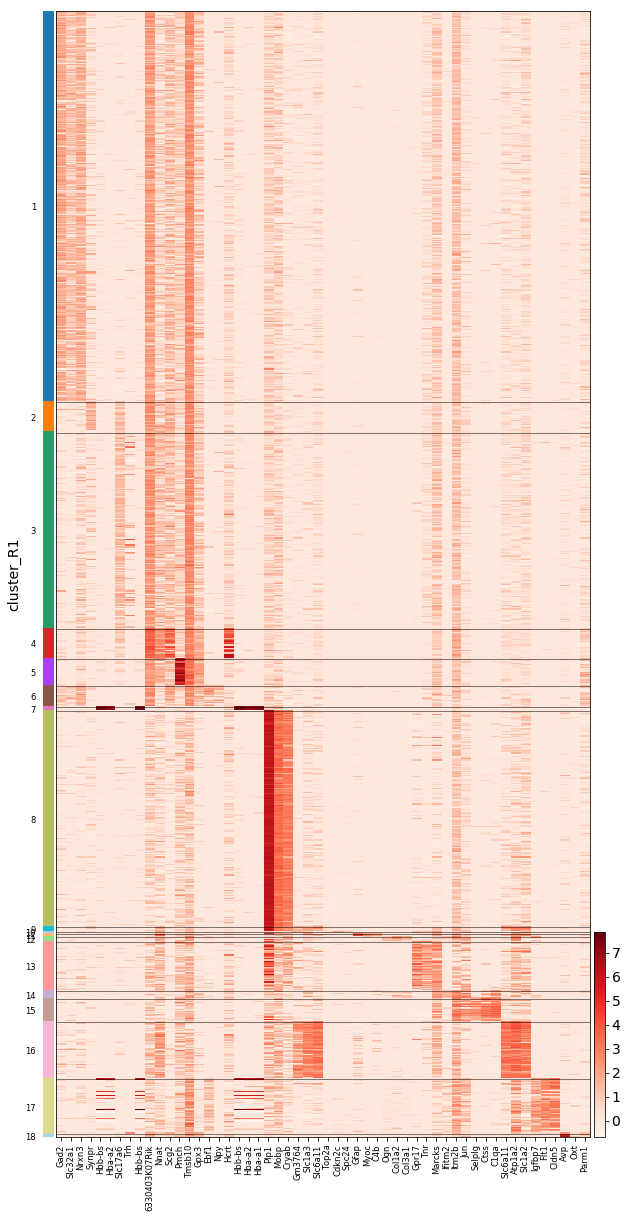

In [53]:
top3_genes = markers.groupby("cluster_R1").head(3).gene_name.values
sc.pl.matrixplot(adata_redux, top3_genes, groupby="cluster_R1", log=True)
sc.pl.dotplot(adata_redux, top3_genes, groupby="cluster_R1", log=True)
sc.pl.heatmap(adata_redux, top3_genes, groupby="cluster_R1", log=True, show_gene_labels=True, figsize=(10, 20))

## Report generation

In [54]:
report = sc.SCBLReport()

In [55]:
report.add_report_figures(adata_redux, 
                          violins=qc_fig1, 
                          scatters=qc_fig2,
                          ranks=[qc_fig3],
                          cluster_key="cluster_R1")

In [56]:
adata_redux.uns["10x_metrics"]["sample"]["Sequencing Saturation"] = 1

In [57]:
report.generate_report(adata_redux)

HTML report saved to [/fastscratch/seignm/singlecell/test_output/AJ17001_20190405_report.html].


## Saving outputs

In [58]:
sc.export_markers(adata_redux, "cluster_R1")

CSV file saved to [/fastscratch/seignm/singlecell/test_output/AJ17001_markers_20190405.csv].
Excel file saved to [/fastscratch/seignm/singlecell/test_output/AJ17001_markers_20190405.xlsx].


In [59]:
redux_save_file = sc.save_adata(adata_redux, "redux")

Saving AJ17001-redux_20190405.h5ad to /fastscratch/seignm/singlecell/test_output.


In [60]:
sc.save_adata_to_rds(adata_redux, cluster_key="cluster_R1")

Saved counts to /fastscratch/seignm/singlecell/test_output/AJ17001_counts.csv.
Saved features to /fastscratch/seignm/singlecell/test_output/AJ17001_features.csv.
Saved umap3d to /fastscratch/seignm/singlecell/test_output/AJ17001_umap3d.csv.
Rds creation submitted as pbs job 9574451.helix-master.
Output will be located in [/fastscratch/seignm/singlecell/test_output].


In [61]:
for k in adata_redux.obs.iterrows():
    print(k)
    break

('AAACCTGAGAATAGGG-1', sequencing_saturation                   NaN
n_genes_by_counts                      1877
log1p_n_genes_by_counts             7.53796
total_counts                           4849
log1p_total_counts                  8.48673
pct_counts_in_top_50_genes          40.4001
pct_counts_in_top_100_genes         46.8756
pct_counts_in_top_200_genes         55.4547
pct_counts_in_top_500_genes         69.9113
total_counts_mitochondrial              530
log1p_total_counts_mitochondrial    6.27476
pct_counts_mitochondrial            10.9301
total_counts_hemoglobin                   0
log1p_total_counts_hemoglobin             0
pct_counts_hemoglobin                     0
n_counts                             5828.5
cluster                                   2
cluster_R1                                8
Name: AAACCTGAGAATAGGG-1, dtype: object)
